# Importar as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas_profiling import ProfileReport

# Ler o arquivo csv e transformá-lo em um pandas dataframe

In [2]:
df = pd.read_csv('dados_preco.csv')
df.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


### No dataframe acima temos 5 features, descrição, criado, qtdInsumos, calculado e correto. No campo descrição temos a quantidade de cápsulas, os insumos utilizados juntamente com sua quantidade. A idéia inicial é extrair a quantidade capsulas utilizada em cada formula. Para tal, o método a seguir realizar esse procedimento, no qual criaremos uma feature no nosso dataframe para armazenar essa informação.

In [3]:
#extrair quantidade de capsulas
def get_cap(text):
    #separar a extring pela |, e pegar o primeiro elemento, ex 30 CAP
    cap = text.split('|')[0]
    #extrair a quantidade de capsulas.
    cap_number = re.search(r'\d+', cap)
    return int(cap_number.group(0))

In [4]:
df['cap'] = df.descricao.apply(get_cap)
df.head()

,descricao,criado,qtdInsumos,calculado,correto,cap
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6,60
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0,120


### A partir do momento que extraímos a quantidade de capsulas, a idéia agora é extrair os insumos utilizado na fórmula e sua quantidade. Para tal, criamos um método que utiliza a ideia do algoritmo bag of words, onde cada token se torna uma feature do nosso dataframe. Porém, não utilizaremos a freqüência da palavra (no nosso caso, do insumo) como valor da feature, e sim a quantidade do insumo utilizado. Também percebemos que cada insumo utiliza uma medida de quantidade distinta, como grama, miligrama, porcentagem e etc. O ideal é termos tudo na mesma escala, porém seria necessário o conhecimento especifico farmacêutico. Todavia, a gente mitigou esse problema posteriormente quando padronizamos a escala de todas as features utilizando a biblioteca StandardScaler do Sklearn.

In [5]:
def get_insumos(df):
   
    #criar lista para armazenar todos os dataframes
    dataframes = list()
    
    #ler todas as linhas do campo descrição
    for i, text in df.descricao.items():
        #criar um dicionário para armazenar o insumo e sua quantidade
        insumos = dict()
        #colocar o texto em minúsculos
        text = text.lower()
        #separar o texto para pegar apenas os insumos
        med = text.split('|')[1]
        #separar os insumos 
        meds = med.split(';')

        #separar o insumo da sua quantidade
        prog = re.compile(r'(\d+.?\d*ui?n?)|(\d+.?\d*m?c?g)|(\d+.?\d*%)|(\d+cap)')
        for m in meds:
            # seperar insumo da sua quantidade
            combo = prog.split(m)
            combo = list(filter(None, combo))
            
            #obter nome do insumo
            insumo = combo[0].strip()
            #obter a quantidade do insumo
            qtde = combo[1].strip()
            qtde = re.search('\d+\.?\d*', qtde).group(0)
            #colocar o insumo e sua quantidade em um dicionário
            insumos[insumo] = [float(qtde)]
            
        #criar dataframe com os insumos utilizado na fórmula    
        new_df = pd.DataFrame(insumos)
        #adicionar o dataframe a lista de frames
        dataframes.append(new_df)
    
    #cocatenar todos os frames
    result = pd.concat(dataframes, ignore_index=True)
            
    
    return result

In [6]:
insumos = get_insumos(df)
insumos.head()

,bupropiona cloridrato,finasterida 1:10,nac,silimarina,same,anastrozol 1:10,dutasterida,tadalafil,triiodotironina slow release,t4,...,glicerina,aloe vera ext glicolico,pca-na,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,l-prolina,trimetilxantina microencapsula
0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,250.0,150.0,50.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.25,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### No dataframe acima temos como features todos os insumos utilizados. Onde cada linha do dataframe apresenta uma fórmula especifica no qual, os insumos utilizado tem sua quantidade e os insumos não utilizado tem valores nulos (NaN). A idéia agora é substituir os valores nulos por zero para representar que o insumo não foi utilizado.

In [7]:
insumos.fillna(0, inplace=True)
insumos.head()
    

,bupropiona cloridrato,finasterida 1:10,nac,silimarina,same,anastrozol 1:10,dutasterida,tadalafil,triiodotironina slow release,t4,...,glicerina,aloe vera ext glicolico,pca-na,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,l-prolina,trimetilxantina microencapsula
0,150.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,250.0,150.0,50.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.25,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Como temos um dataframe com os insumos de cada fórmula, e outro dataframe com as outras informações, temos agora que juntar os dois dataframes.

In [8]:
new_data = pd.concat([insumos, df], axis=1)
new_data.head()

,bupropiona cloridrato,finasterida 1:10,nac,silimarina,same,anastrozol 1:10,dutasterida,tadalafil,triiodotironina slow release,t4,...,bacteroides fragilis,andarine,l-prolina,trimetilxantina microencapsula,descricao,criado,qtdInsumos,calculado,correto,cap
0,150.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60
2,0.0,0.0,250.0,150.0,50.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60
3,0.0,0.0,0.0,0.0,0.0,0.3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6,60
4,0.0,0.0,0.0,0.0,0.0,0.0,0.25,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0,120


### Como já extrairmos todas as informações do campo descrição, podemos então removê-lo do nosso daframe. Assim como, iremos remover o campo criado, pois não tem nenhuma significância para predição.

In [9]:
new_data.drop(columns=['descricao', 'criado'], inplace=True)
new_data.head()

,bupropiona cloridrato,finasterida 1:10,nac,silimarina,same,anastrozol 1:10,dutasterida,tadalafil,triiodotironina slow release,t4,...,base creme,dlfenilalanina,bacteroides fragilis,andarine,l-prolina,trimetilxantina microencapsula,qtdInsumos,calculado,correto,cap
0,150.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,47.5297,39.9,30
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,46.9620,43.6,60
2,0.0,0.0,250.0,150.0,50.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,105.1390,111.4,60
3,0.0,0.0,0.0,0.0,0.0,0.3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,49.0314,43.6,60
4,0.0,0.0,0.0,0.0,0.0,0.0,0.25,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,161.8272,146.0,120


### A partir do momento que temos nosso dataframe com todas as informações necessária, agora a idéia e verificar o comportamento das outras features e da variável alvo. Para isso, utilizaremos a biblioteca pandas profile que nos dará um relatório completo sobre essas features.

In [10]:
report_data = new_data[['qtdInsumos','calculado','correto', 'cap']].copy()
profile = ProfileReport(report_data, title='Report',html={'style':{'full_width':True}})
profile

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### No reporte acima podemos ver que todas as features e a variável alvo não obedecem a uma distribuição normal, apresentando um alto grau de assimetria. Temos que tratar tal assimetria pois como nossos dados estão distorcidos positivamente, isso significa que há um número maior de pontos de dados com valores baixos. Portanto, quando treinarmos nosso modelo com esses dados, ele terá um desempenho melhor na previsão utilizando os menores valores em relação a os maiores valores. Assim como, a assimetria apresenta a direção dos nosso outliers. Então, se suavisamos a assimetria utilizando uma transformação logaritma por exemplo, para a distribuição ficar mais parecida com a distribuição normal, iremos suavizar o impacto dos outliers nos nossos modelos. Também vimos que não há uma correlação significativa da quantidade de cápsulas e a quantidade de insumos em relação a variável alvo. Dependendo da quantidade da dados que temos, e do objetivo em questão, as vezes eliminar os outliers é uma boa opção. Todavia, no nosso caso temos 514 fórmulas com valores que distoncem da distribuição (outliers) um número alto para a quantidade de dados que temos. 

In [11]:
###detectando a quantidade de outliers na variável alvo.
max = 161.2 + (1.5 * (161.2-49.5))
df_m = df.loc[df['correto'] > max]
df_m.shape

(514, 6)

In [12]:
insumos_m = get_insumos(df_m)
insumos_m.head()

,gestrinona 1:10,imuno tf,saw palmeto ext seco,dutasterida,exsynutriment-silicio organico,cisteina cloridrato anidra,cistina,clomifeno citrato,biotina,ostarine,...,psilium,castanha da india,açafrão,pimentar preta,l glutamina,euterpe oleracea ext seco,wellmune,andarine,l-prolina,greenselect
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,700.0,0.1,300.0,100.0,100.0,30.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Também verificamos se há algum insumo que está presente em todas as fórmulas com os valores considerados outliers. Que no nosso caso, não há.

In [13]:
df_test = insumos_m[insumos_m.columns[~insumos_m.isnull().any()]]
df_test.head()

""
0
1
2
3
4


# Suavisando a assimetria das features e da variável alvo.

Skew:  23.719577117774104


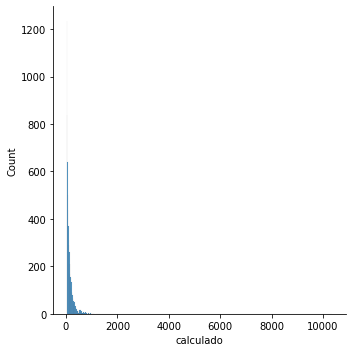

In [14]:
print("Skew: ",new_data['calculado'].skew())
sns.displot(new_data['calculado'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='calculado'>

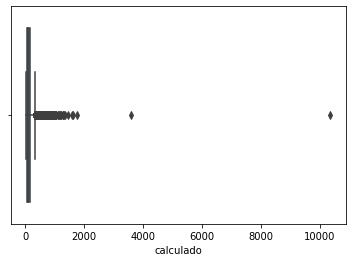

In [15]:
sns.boxplot(new_data['calculado'])

Skew:  0.5910328220862269


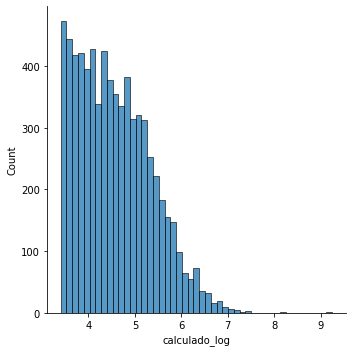

In [16]:
new_data['calculado_log'] = np.log(new_data['calculado']) 
print("Skew: ",new_data['calculado_log'].skew())
sns.displot(new_data['calculado_log'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='calculado_log'>

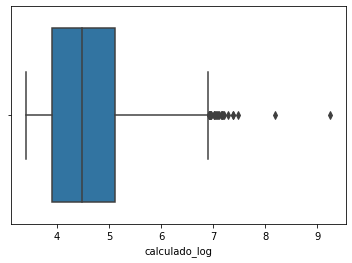

In [17]:
sns.boxplot(new_data['calculado_log'])

Skew:  2.1535490645825104


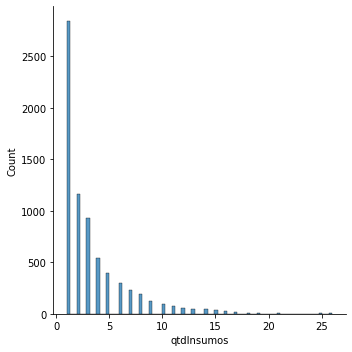

In [18]:
print("Skew: ",new_data['qtdInsumos'].skew())
sns.displot(new_data['qtdInsumos'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qtdInsumos'>

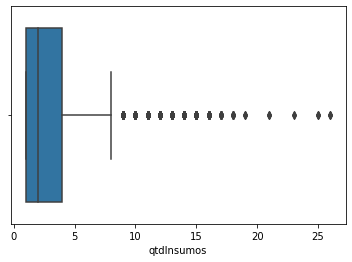

In [19]:
sns.boxplot(new_data['qtdInsumos'])

Skew:  0.5352972809794284


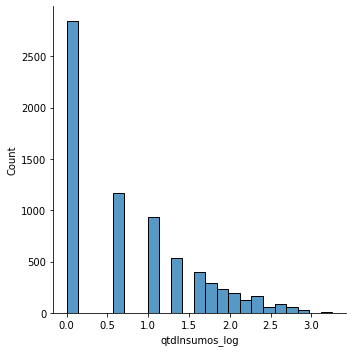

In [20]:
new_data['qtdInsumos_log'] = np.log(new_data['qtdInsumos']) 
print("Skew: ",new_data['qtdInsumos_log'].skew())
sns.displot(new_data['qtdInsumos_log'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qtdInsumos_log'>

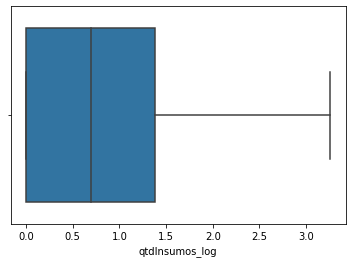

In [21]:
sns.boxplot(new_data['qtdInsumos_log'])

Skew:  3.9227515476645403


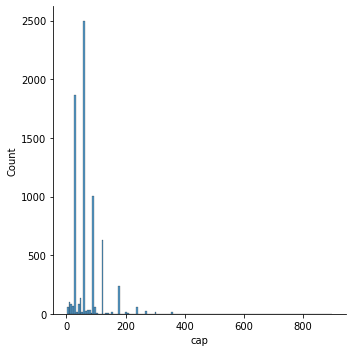

In [22]:
print("Skew: ",new_data['cap'].skew())
sns.displot(new_data['cap'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cap'>

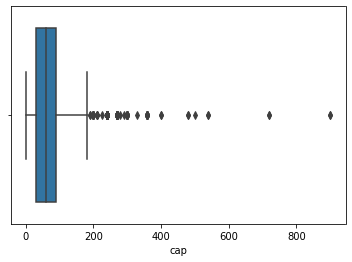

In [23]:
sns.boxplot(new_data['cap'])

Skew:  -0.5103817098040356


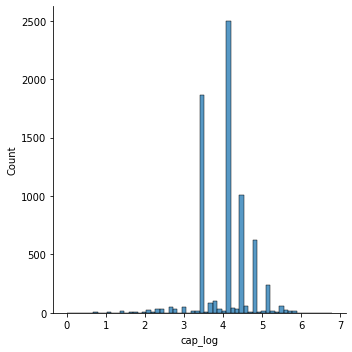

In [24]:
new_data['cap_log'] = np.log(new_data['cap']) 
print("Skew: ",new_data['cap_log'].skew())
sns.displot(new_data['cap_log'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cap_log'>

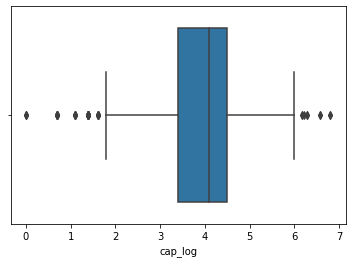

In [25]:
sns.boxplot(new_data['cap_log'])

Skew:  24.115348449684962


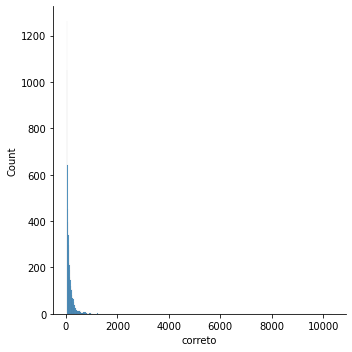

In [26]:
print("Skew: ",new_data['correto'].skew())
sns.displot(new_data['correto'])

/home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='correto'>

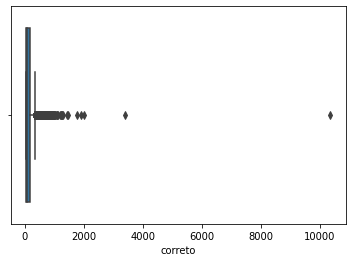

In [27]:
sns.boxplot(new_data['correto'])

Skew:  0.7908950150578311


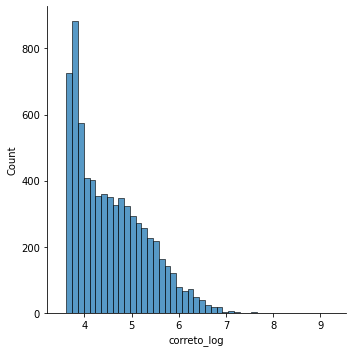

In [28]:
new_data['correto_log'] = np.log(new_data['correto']) 
print("Skew: ",new_data['correto_log'].skew())
sns.displot(new_data['correto_log'])

<AxesSubplot:xlabel='correto_log'>

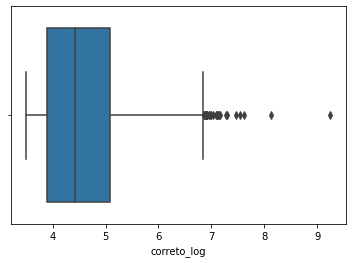

In [29]:
sns.boxplot(x="correto_log", data=new_data)

### Embora as features calculado, quantidade de insumos e correto estão na mesma escala, as outras features não estão. Para evitar que nosso algoritmo fique enviesado para as variáveis com maior ordem de grandeza, temos que padronizar todas para uma unica escala. Para tal, utilizaremos a biblioteca StandardScaler do sklearn, onde nos retornará uma distribuição com média zero e desvio padrão 1.

In [30]:
features_name = new_data.columns.to_list()
target_name = "correto_log"
features_name.remove(target_name)
features = new_data.drop(columns='correto_log')

target = new_data['correto_log'].copy()
scaler = StandardScaler()
features = scaler.fit_transform(X=features)

In [31]:
scaled_features = pd.DataFrame(data=features, columns=features_name)
scaled_features = pd.concat([scaled_features, target], axis=1)
scaled_features.head()

,bupropiona cloridrato,finasterida 1:10,nac,silimarina,same,anastrozol 1:10,dutasterida,tadalafil,triiodotironina slow release,t4,...,l-prolina,trimetilxantina microencapsula,qtdInsumos,calculado,correto,cap,calculado_log,qtdInsumos_log,cap_log,correto_log
0,11.050693,-0.015966,-0.093204,-0.116231,-0.049947,-0.018945,-0.058792,-0.081517,-0.047839,-0.128641,...,-0.011851,-0.011851,-0.714398,-0.468279,-0.505769,-0.766575,-0.890862,-1.014227,-0.955406,3.686376
1,-0.082865,16.226200,-0.093204,-0.116231,-0.049947,-0.018945,-0.058792,-0.081517,-0.047839,-0.128641,...,-0.011851,-0.011851,-0.714398,-0.471248,-0.486274,-0.171792,-0.906122,-1.014227,0.104691,3.775057
2,-0.082865,-0.015966,7.930343,4.897177,2.984832,-0.018945,-0.058792,-0.081517,-0.047839,-0.128641,...,-0.011851,-0.011851,-0.088239,-0.167059,-0.129044,-0.171792,0.117371,0.331941,0.104691,4.713127
3,-0.082865,-0.015966,-0.093204,-0.116231,-0.049947,0.025131,-0.058792,-0.081517,-0.047839,-0.128641,...,-0.011851,-0.011851,-0.714398,-0.460427,-0.486274,-0.171792,-0.851360,-1.014227,0.104691,3.775057
4,-0.082865,-0.015966,-0.093204,-0.116231,-0.049947,-0.018945,8.314381,17.350382,-0.047839,-0.128641,...,-0.011851,-0.011851,-0.401319,0.129345,0.053259,1.017774,0.665022,-0.164890,1.164789,4.983607


### Como nosso dados já estão pré-processados, vamos eliminar as features duplicadas e dividir nossos dados de em treino e teste.

In [32]:
df_log = scaled_features.drop(columns=['correto', 'calculado', 'cap', 'qtdInsumos'])
train = df_log[:5121]
test = df_log[5121:]

### Para reduzir nosso tempo testando vários algoritmos, escolhendo um e otimizando, utizaremos uma biblioteca de automl que já realiza esse processo para gente. O h2o é uma biblioteca de auto ML que realiza esse processo para gente. 

In [33]:
### Iniciando o H2o framework
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/tullyo/anaconda3/envs/av/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl8tjdkud
  JVM stdout: /tmp/tmpl8tjdkud/h2o_tullyo_started_from_python.out
  JVM stderr: /tmp/tmpl8tjdkud/h2o_tullyo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Recife
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_tullyo_vj6bda
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.924 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


### Definimos o H2o para testar todos os algortimos supervisionados contido na sua biblioteca exceto algoritmos de deepLearning. Pois devido a pouca quantidade de dados, dificilmente um algoritmo de deep learnig teria bom desempenho na tarefa. Também, retrigimos o H2o a testar diversos algortimos por 24 horas e escolher o melhor pelo Root Mean Squared Error. Nessa métrica predições muito distantes do real aumentam o valor da medida muito facilmente, o que a torna uma métrica de avaliação excelente para problemas nos quais grandes erros não são tolerados, como é o caso de projeções de preços.

In [34]:
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

x = train.columns
y = "correto_log"
x.remove(y)

aml = H2OAutoML(max_runtime_secs=86400, seed=42, exclude_algos=['DeepLearning'], sort_metric='RMSE')
aml.train(x=x, y=y, training_frame=train, validation_frame=test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
02:05:24.117: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


### Ranking dos algoritmos testados ordenado pelo RMSE

In [35]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

model_id,rmse,mean_residual_deviance,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
XGBoost_grid__1_AutoML_20210920_020524_model_3,0.132005,0.0174253,0.0174253,0.0596408,0.0224488,4275,0.019323,XGBoost
GBM_grid__1_AutoML_20210920_020524_model_76,0.132103,0.0174512,0.0174512,0.0662189,0.0223613,16526,0.021253,GBM
XGBoost_grid__1_AutoML_20210920_020524_model_28,0.133254,0.0177565,0.0177565,0.0637208,0.0225835,7407,0.015825,XGBoost
XGBoost_grid__1_AutoML_20210920_020524_model_9,0.133323,0.0177749,0.0177749,0.0618576,0.0224731,12785,0.015865,XGBoost
XGBoost_grid__1_AutoML_20210920_020524_model_36,0.133345,0.017781,0.017781,0.063478,0.0224647,5022,0.013903,XGBoost
XGBoost_grid__1_AutoML_20210920_020524_model_2,0.133512,0.0178255,0.0178255,0.0672866,0.0226328,3920,0.014105,XGBoost
GBM_grid__1_AutoML_20210920_020524_model_24,0.133737,0.0178857,0.0178857,0.0617989,0.0224638,16537,0.019152,GBM
GBM_grid__1_AutoML_20210920_020524_model_83,0.133745,0.0178877,0.0178877,0.0620156,0.0224586,22745,0.019253,GBM
XGBoost_grid__1_AutoML_20210920_020524_model_19,0.134127,0.01799,0.01799,0.0630862,0.0224773,15332,0.017575,XGBoost
XGBoost_grid__1_AutoML_20210920_020524_model_12,0.134281,0.0180313,0.0180313,0.0612706,0.0225801,15929,0.01492,XGBoost


### As linhas abaixo apresentam os resultados obtidos com o melhor modelo de acordo com o ranking. Assim como, as características do modelo, como número de árvores. Também é possível ver quais variáveis impactam mais o modelo.

In [36]:
best = aml.get_best_model()
best

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210920_020524_model_3


Model Summary: 


,,number_of_trees
0,,45.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0045172783090846845
RMSE: 0.06721070085250327
MAE: 0.04467829594596292
RMSLE: 0.01222266652204459
Mean Residual Deviance: 0.0045172783090846845

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.021152557527495588
RMSE: 0.14543918841734366
MAE: 0.06362916696071624
RMSLE: 0.025008417828088925
Mean Residual Deviance: 0.021152557527495588

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.017425348535120216
RMSE: 0.13200510798874496
MAE: 0.059640759393773585
RMSLE: 0.022448770216501965
Mean Residual Deviance: 0.017425348535120216

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.059641276,0.002879607,0.05698889,0.06369574,0.06162309,0.058093797,0.057804868
1,mean_residual_deviance,0.017424904,0.0045905565,0.01970314,0.022570403,0.019393075,0.011204378,0.014253521
2,mse,0.017424904,0.0045905565,0.01970314,0.022570403,0.019393075,0.011204378,0.014253521
3,r2,0.968636,0.0073701204,0.96498734,0.9592206,0.96739936,0.9781871,0.9733857
4,residual_deviance,0.017424904,0.0045905565,0.01970314,0.022570403,0.019393075,0.011204378,0.014253521
5,rmse,0.13102005,0.01798092,0.14036788,0.15023449,0.13925903,0.105850734,0.11938811
6,rmsle,0.02232066,0.0026763245,0.023039952,0.025864622,0.023238463,0.018920885,0.020539377



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-09-20 02:33:13,1 min 19.375 sec,0.0,4.131742,4.064335,17.071296,4.159121,4.085396,17.298286
1,,2021-09-20 02:33:14,1 min 20.122 sec,5.0,0.705922,0.684796,0.498326,0.727192,0.697734,0.528809
2,,2021-09-20 02:33:14,1 min 20.579 sec,10.0,0.153716,0.120349,0.023628,0.199326,0.133009,0.039731
3,,2021-09-20 02:33:15,1 min 21.001 sec,15.0,0.089552,0.052159,0.008020,0.150574,0.066401,0.022672
4,,2021-09-20 02:33:15,1 min 21.423 sec,20.0,0.082301,0.051262,0.006773,0.148307,0.066362,0.021995
5,,2021-09-20 02:33:16,1 min 21.846 sec,25.0,0.077995,0.049687,0.006083,0.146064,0.065531,0.021335
6,,2021-09-20 02:33:16,1 min 22.268 sec,30.0,0.075020,0.048175,0.005628,0.146063,0.065012,0.021335
7,,2021-09-20 02:33:16,1 min 22.725 sec,35.0,0.072382,0.047122,0.005239,0.145711,0.064718,0.021232
8,,2021-09-20 02:33:17,1 min 23.149 sec,40.0,0.069781,0.045769,0.004869,0.145518,0.064328,0.021176
9,,2021-09-20 02:33:17,1 min 23.573 sec,45.0,0.067211,0.044678,0.004517,0.145439,0.063629,0.021153



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,calculado_log,4231.174316,1.000000,0.967968
1,cap_log,24.679525,0.005833,0.005646
2,vitamina k2 mk7,10.150913,0.002399,0.002322
3,bioferrin,7.603527,0.001797,0.001739
4,andarina,6.879789,0.001626,0.001574
5,lactoferrina,6.602421,0.001560,0.001510
6,booster osteoarticular,5.945363,0.001405,0.001360
7,vitamina d3,5.831487,0.001378,0.001334
8,vitamina d liq,5.805334,0.001372,0.001328
9,qtdInsumos_log,5.237826,0.001238,0.001198



See the whole table with table.as_data_frame()


In [37]:
best.actual_params

{'model_id': 'XGBoost_grid__1_AutoML_20210920_020524_model_3',
 'training_frame': 'automl_training_Key_Frame__upload_a884be0adf14cab54f870cd5e0ce4d35.hex',
 'validation_frame': 'Key_Frame__upload_8458410d527cfcee74f8e2d69c0c4683.hex',
 'nfolds': 5,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'response_column': 'correto_log',
 'ignored_columns': [],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': 'RMSE',
 'stopping_tolerance': 0.013974060271677285,
 'max_runtime_secs': 0.0,
 'seed': 77804,
 'distribution': 'gaussian',
 'tweedie_power': 1.5,
 'categorical_encoding': 'OneHotInternal',
 'quiet_mode': True,
 'checkpoint': None,
 'export_checkpoints_dir': None,
 'ntrees': 45,
 'max_depth': 5,
 'min_rows': 1.0,
 'min_child_weight': 1.0,
 'learn_rate':

### Utilizamos o modelo gerado para realizar a prever os dados de teste

In [38]:
preds = best.predict(test)
preds

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
3.84335
4.95327
3.8685
3.89572
3.89812
4.23668
4.19503
5.46447
4.83222
4.65923


In [39]:
result = pd.DataFrame()
result['pred'] =  h2o.as_list(preds)
result['gt'] = h2o.as_list(test['correto_log'])
result.head()

,pred,gt
0,3.843349,3.775057
1,4.953269,4.953712
2,3.868504,3.871201
3,3.895715,3.871201
4,3.898123,4.107590


### Como fizemos a transformação logarítmica na fase de pré-processamento, faz necessário reverter a transformação aplicando a função inversa (exponencial) para obter os valores reais.

In [40]:
result['pred'] = np.exp(result['pred'])
result['gt'] = np.exp(result['gt'])

### A seguir apresentamos o gráfico de regressão para comparar os dados reais para o que foi previsto. Esse gráfico tem a ideia de quanto mais próximo da linha de regressão os dados estão, melhor nosso modelo é. Sendo assim, é possível ver que na maioria dos casos nosso modelo está bem ajustado, pois os dados na maioria dos casos estão bem próximo da linha de regressão. Todavia, há existencia de outliers que irão elevar nossas métricas como RMSE e MSE.

<AxesSubplot:xlabel='pred', ylabel='gt'>

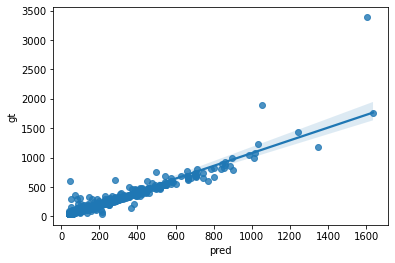

In [41]:
sns.regplot(x="pred", y="gt", data=result)


### Vamos a seguir obter as métricas levando em consideração os valores reais. Analisaremos o RMSE (Root Mean Square Erro) como já explicamos acima, R² e MAE. O R² varia de 0 a 1 e geralmente é representado em porcentagem. Por exemplo, um R² = 60% nos diz que 60% da variância de nossos dados podem ser explicados pelo modelo construído, enquanto os outros 40%, teoricamente, se tratariam de uma variância residual. Já o MAE (Mean Absolut Error)  consiste na média das distâncias entre valores preditos e reais. Diferentemente do RMSE, essa métrica não “pune” tão severamente os outliers do modelo.

In [52]:
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error

rmse = mean_squared_error(result['gt'], result['pred'], squared=False)
r2 = r2_score(result['gt'], result['pred'])
mae = mean_absolute_error(result['gt'], result['pred'])

print("RMSE:", float("{:.2f}".format(rmse)))
print("R2:", float("{:.2f}".format(r2)))
print("MAE:", float("{:.2f}".format(mae)))

RMSE: 52.27
R2: 0.91
MAE: 10.96


# Conclusão

### Nosso modelo é bem ajustado para a maioria dos casos, porém quando a fórmula tende a ter um valor muito alto, nosso modelo não é capaz de prever bem esse valor, com isso a métrica RMSE ficou elavada pois foi gravimente afetada por tais valores. A métrica MAE apresenta bem o impacto dos outliers no nosso modelo, pois como ela não pune severamente esses dados temos um valor bem menor comparado ao RMSE, mesmo que sejam métricas diferentes, podemos perceber o quão os outliers estão impactando nosso modelo. Talvez, se tivermos mais dados no treinamento com altos valores, conseguiremos prever esses dados com mais corretude. Todavia, a métrica R² nos mostrou que nosso modelo explica 91% dos dados de teste, uma taxa relativamente alta considerando o contexto.